In [15]:
from MINE import MineOpt, MineClassif
from MINE.augmentation import *
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Model
from tensorflow.keras import models as keras_models
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams['figure.figsize'] = 20, 15
import os
import pickle
import pandas as pd
import seaborn as sns
import re

SMALL_SIZE = 10
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [16]:
def prepare_datasets(n, seed):
    tf.keras.utils.set_random_seed(seed)
    aug = Augmentation()

    uni = create_uni(n, 16)
    uni_aug = aug.transform(uni, n=10, m=1)

    mean = np.array([0, 1])
    cov = np.array([[1, 0], [0, 2]])
    norm_not_corr = np.random.multivariate_normal(mean=mean, cov=cov, size=n)
    norm_not_corr_aug = aug.transform(norm_not_corr, n=10, m=1)


    mean = np.array([0, 1])
    cov = np.array([[1, 0.75], [0.75, 2]])
    norm_corr = np.random.multivariate_normal(mean=mean, cov=cov, size=n)
    norm_corr_aug = aug.transform(norm_corr, n=10, m=1)

    mean = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
    np.random.seed(77)
    A = np.random.uniform(-1, 1, 81).reshape(9, 9)
    cov = np.matmul(A, A.T)
    norm_hd = np.random.multivariate_normal(mean=mean, cov=cov, size=n)
    norm_hd_aug = aug.transform(norm_hd, n=10, m=1)

    datasets = {'uni': uni,
               'uni_aug': uni_aug,
               'norm_not_corr': norm_not_corr,
               'norm_not_corr_aug': norm_not_corr_aug,
               'norm_corr': norm_corr,
               'norm_corr_aug': norm_corr_aug,
               'norm_hd': norm_hd,
               'norm_hd_aug': norm_hd_aug}
    return datasets

In [17]:
def theoretical(dataset):
    if dataset == 'uni':
        return np.log(16)
    if dataset == 'norm_not_corr':
        return 0
    if dataset == 'norm_corr':
        cov = np.array([[1, 0.75], [0.75, 2]])
        corr = cov[0, 1] / np.sqrt(np.diag(cov)).prod()
        return -0.5*np.log(1 - corr**2)
    
    mean = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
    np.random.seed(77)
    A = np.random.uniform(-1, 1, 81).reshape(9, 9)
    cov = np.matmul(A, A.T)
    cov = cov.round(2)
    
    cov2 = cov.copy()
    cov2[:4, -4:] = 0
    cov2[-4:, :4] = 0
    cov2 = np.delete(np.delete(cov2, 4, axis=0), 4, axis=1).round(2)
    
    cov = np.delete(np.delete(cov, 4, axis=0), 4, axis=1).round(2)
    
    return 0.5*(np.log(np.linalg.det(cov2) / np.linalg.det(cov)) - 8 + np.trace(np.matmul(np.linalg.inv(cov2), cov)))

# Results

In [18]:
with open('clean_results/results_initial.pkl', 'rb') as fd:
    d = pickle.load(fd)

In [19]:
d.dataset = d.dataset.apply(lambda x: re.sub('_aug', '', x))
d.reg = d.reg.astype(str).apply(lambda x: f'lam={x}')
d.approx = d.approx.astype(str)

In [20]:
d.groupby(['dataset', 'dataset_ver', 'method', 'approx', 'reg', 'n']).size().unique()

array([1000,  100], dtype=int64)

In [21]:
d_aug = d.loc[d.dataset_ver == 'aug'].groupby(['dataset', 'n', 'method', 'approx', 'reg', 'seed'])['mi'].mean().reset_index()
d_aug['dataset_ver'] = 'aug'
d_aug['history'] = None

d = pd.concat((d.loc[d.dataset_ver != 'aug'], d_aug))

In [22]:
d['method_full'] = d.loc[:, ['method', 'approx', 'reg']].apply(lambda x: ' '.join(x) if x['method'] != 'ksg' else 'ksg', axis=1)

In [23]:
d.groupby(['dataset', 'dataset_ver', 'method', 'approx', 'reg', 'n']).size().unique()

array([100], dtype=int64)

In [24]:
d.groupby(['dataset', 'dataset_ver', 'method_full', 'n']).size().unique()

array([100], dtype=int64)

In [25]:
d.head()

,dataset,dataset_ver,n,method,approx,reg,seed,mi,history,method_full
0,uni,orig,100,opt,DV,lam=0.0,419578,1.910404,"{'mi': [-0.028482038527727127, -0.033513527363...",opt DV lam=0.0
1,uni,orig,100,opt,DV,lam=0.1,419578,1.941296,"{'mi': [-0.031074389815330505, -0.028770625591...",opt DV lam=0.1
2,uni,orig,100,opt,FD,lam=0.0,419578,1.764967,"{'mi': [-0.384560227394104, -0.363346546888351...",opt FD lam=0.0
3,uni,orig,100,opt,FD,lam=0.1,419578,1.935687,"{'mi': [-0.31775134801864624, -0.2978672385215...",opt FD lam=0.1
4,uni,orig,100,classif,DV,lam=0.0,419578,2.225209,"{'mi': [-0.030394213274121284, -0.021599419414...",classif DV lam=0.0


In [27]:
d['residual'] = d.apply(lambda x: theoretical(x['dataset']) - x['mi'], axis=1)

c:\python\python39\lib\site-packages\numpy\lib\function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\python\python39\lib\site-packages\numpy\lib\function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


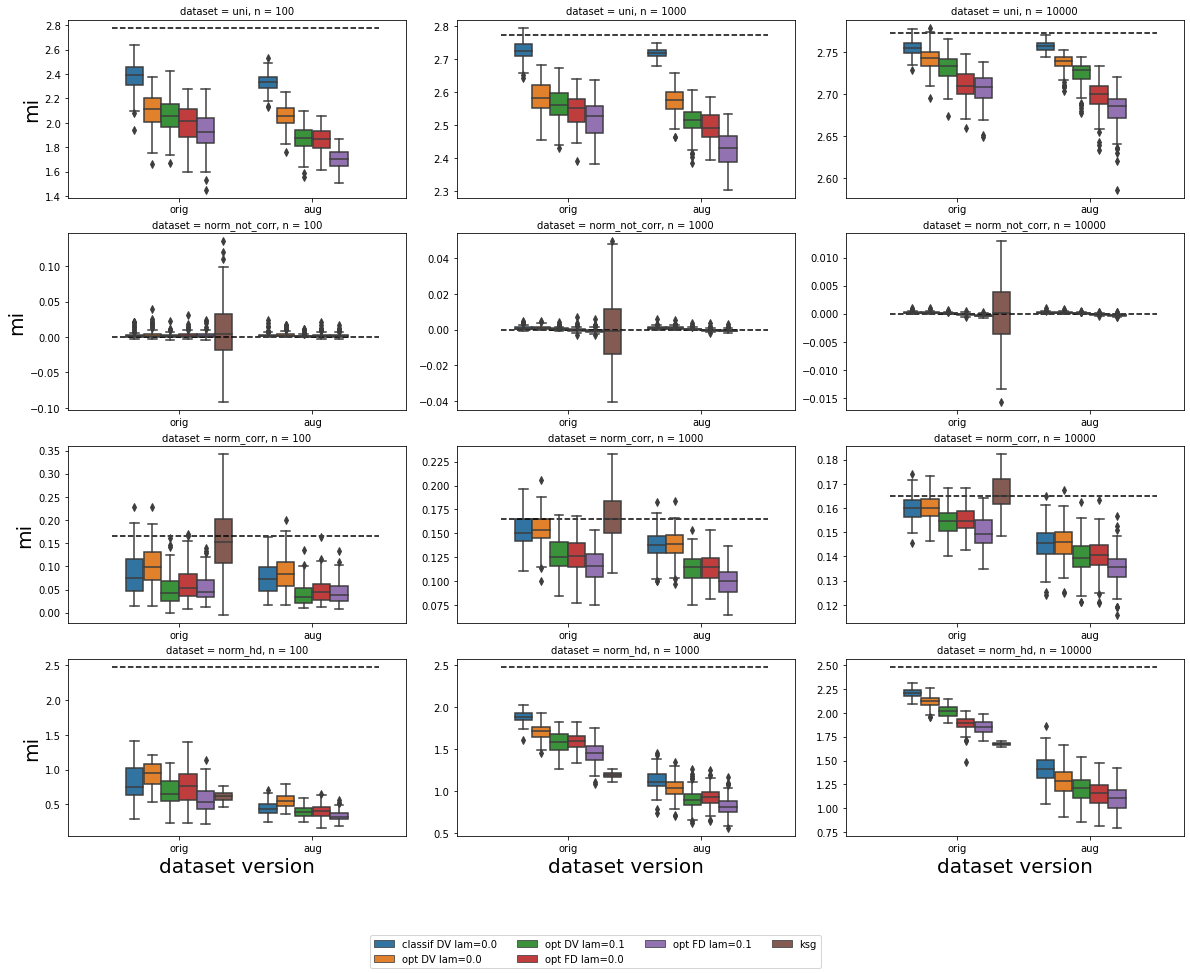

In [55]:
fig, ax = plt.subplots(4, 3)
for i, dataset in enumerate(['uni', 'norm_not_corr', 'norm_corr', 'norm_hd']):
    for j, n in enumerate([100, 1000, 10000]):
        sns.boxplot(x='dataset_ver', y='mi', hue='method_full', data=d.loc[(d.dataset == dataset) & (d.n == n)], ax=ax[i][j],
                   hue_order=['classif DV lam=0.0', 'opt DV lam=0.0', 'opt DV lam=0.1', 'opt FD lam=0.0', 'opt FD lam=0.1', 'ksg'],
                   order=['orig', 'aug'])
        t = theoretical(dataset)
#         print(t)
        ax[i][j].hlines(t, -0.5, 1.5, color='black', linestyle='--')
        if i != 3:
            ax[i][j].set_xlabel(None)
        else:
            ax[i][j].set_xlabel('dataset version')
        if j != 0:
            ax[i][j].set_ylabel(None)
        ax[i][j].set_title(f'dataset = {dataset}, n = {n}')
        handles, labels = ax[i][j].get_legend_handles_labels()
        ax[i][j].get_legend().remove()

plt.subplots_adjust(wspace=0.15)
fig.legend(handles, labels, loc="lower center", ncol=4)
plt.savefig(f'plots/initial/boxplots.png', bbox_inches='tight')

c:\python\python39\lib\site-packages\numpy\lib\function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\python\python39\lib\site-packages\numpy\lib\function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


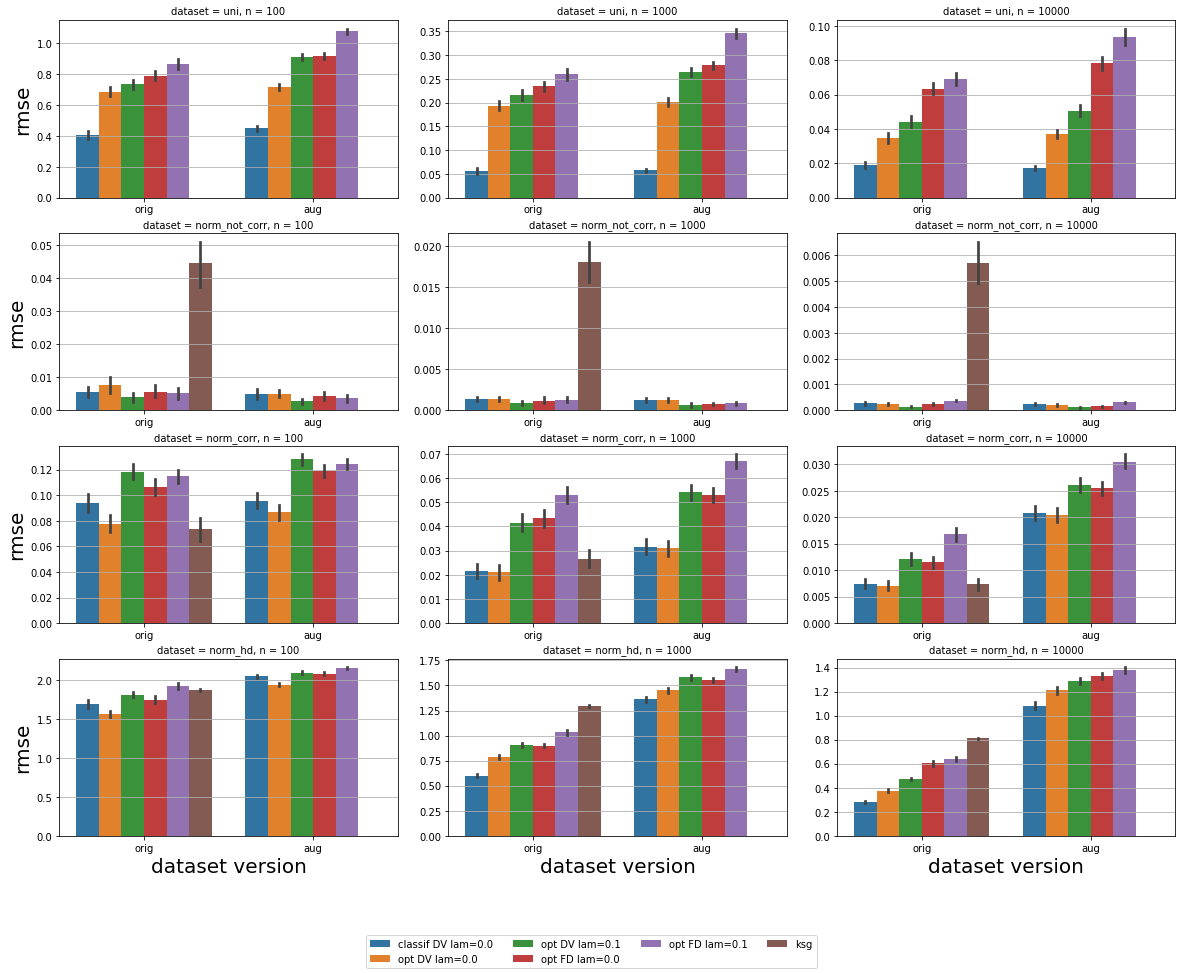

In [57]:
fig, ax = plt.subplots(4, 3)
for i, dataset in enumerate(['uni', 'norm_not_corr', 'norm_corr', 'norm_hd']):
    for j, n in enumerate([100, 1000, 10000]):
        sns.barplot(x='dataset_ver', y='residual', hue='method_full', data=d.loc[(d.dataset == dataset) & (d.n == n)], ax=ax[i][j],
                   hue_order=['classif DV lam=0.0', 'opt DV lam=0.0', 'opt DV lam=0.1', 'opt FD lam=0.0', 'opt FD lam=0.1', 'ksg'],
                   order=['orig', 'aug'], estimator=lambda x: np.sqrt(np.mean(x**2)))
        if i != 3:
            ax[i][j].set_xlabel(None)
        else:
            ax[i][j].set_xlabel('dataset version')
        if j != 0:
            ax[i][j].set_ylabel(None)
        else:
            ax[i][j].set_ylabel('rmse')
        ax[i][j].set_title(f'dataset = {dataset}, n = {n}')
        
        ax[i][j].grid(axis='y')
        handles, labels = ax[i][j].get_legend_handles_labels()
        ax[i][j].get_legend().remove()

plt.subplots_adjust(wspace=0.15)
fig.legend(handles, labels, loc="lower center", ncol=4)
plt.savefig(f'plots/initial/barplots.png', bbox_inches='tight')

In [134]:
def aggregate(results):
    if not isinstance(results, dict):
        return np.array([np.mean(results, where=~np.isnan(results)), np.std(results, where=~np.isnan(results)) / (~np.isnan(results)).sum()])
    else:
        aggs = {}
        for key, value in results.items():
            aggs[key] = aggregate(value)
            
        return aggs

In [135]:
agg_results = aggregate(results)

In [136]:
import seaborn as sns

In [137]:
def data_for_boxplot(n, dataset):
    tmp = pd.DataFrame(results[dataset][n]['orig']['DV']).melt(var_name='regularization', value_name='mi_estimate')
    tmp['approx'] = 'DV'
    tmp['dataset'] = 'orig'
    
    tmp2 = pd.DataFrame({'regularization': 30*[''], 'mi_estimate': results[dataset][n]['orig']['FD'], 'approx': ['FD']*30})
    tmp2['dataset'] = 'orig'
    tmp = pd.concat((tmp, tmp2))
    
    tmp2 = pd.DataFrame(results[dataset][n]['aug'][1]['DV']).melt(var_name='regularization', value_name='mi_estimate')
    tmp2['approx'] = 'DV'
    tmp2['dataset'] = 'aug'
    tmp = pd.concat((tmp, tmp2))
    
    tmp2 = pd.DataFrame({'regularization': 30*[''], 'mi_estimate': results[dataset][n]['aug'][1]['FD'], 'approx': ['FD']*30})
    tmp2['dataset'] = 'aug'
    tmp = pd.concat((tmp, tmp2))
    
    tmp['model'] = tmp.loc[:, ['approx', 'regularization']].apply(lambda x: ' '.join(x), axis=1)
    
    return tmp

In [8]:
def theoretical(dataset):
    if dataset == 'uni':
        return np.log(16)
    if dataset == 'norm_not_corr':
        return 0
    if dataset == 'norm_corr':
        cov = np.array([[1, 0.75], [0.75, 2]])
        corr = cov[0, 1] / np.sqrt(np.diag(cov)).prod()
        return -0.5*np.log(1 - corr**2)
    
    cov2 = cov_hd.copy()
    cov2[:4, -4:] = 0
    cov2[-4:, :4] = 0
    cov2 = np.delete(np.delete(cov2, 4, axis=0), 4, axis=1).round(2)
    
    cov = np.delete(np.delete(cov_hd, 4, axis=0), 4, axis=1).round(2)
    
    return 0.5*(np.log(np.linalg.det(cov2) / np.linalg.det(cov)) - 8 + np.trace(np.matmul(np.linalg.inv(cov2), cov)))

In [9]:
theoretical('norm_hd')

1.0379057965915144

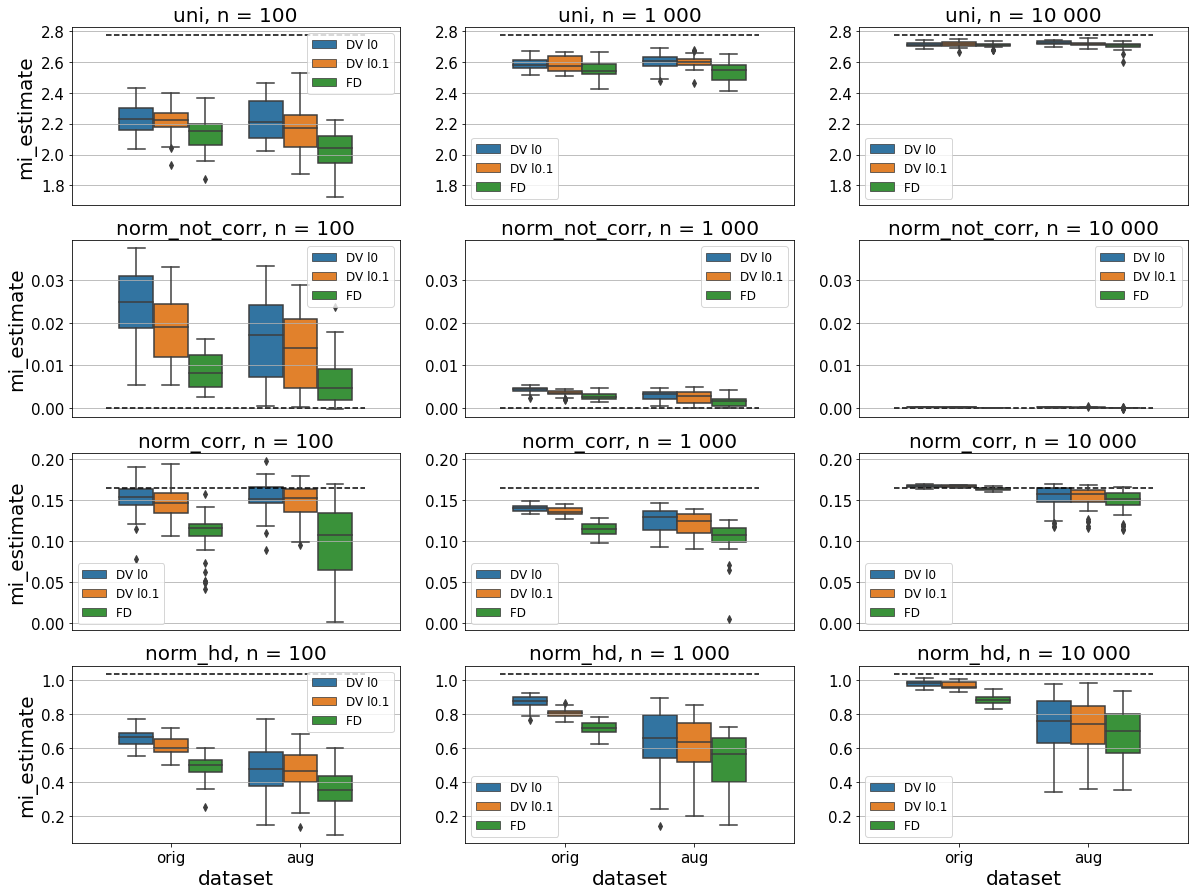

In [201]:
for i, dataset in enumerate(['uni', 'norm_not_corr', 'norm_corr', 'norm_hd']):
    ax = plt.subplot(4, 3, i*3+1)
    sns.boxplot(x='dataset', y='mi_estimate', hue='model', data=data_for_boxplot(100, dataset))
    plt.hlines(theoretical(dataset), *plt.xlim(), color='black', linestyle='--')
    plt.grid(axis='y')
    plt.title(dataset + ", n = 100", size=20)
    if i != 3:
        plt.xlabel('')
        plt.xticks([])
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.legend(fontsize=12)

    plt.subplot(4, 3, i*3+2, sharey=ax)
    sns.boxplot(x='dataset', y='mi_estimate', hue='model', data=data_for_boxplot(1000, dataset))
    plt.hlines(theoretical(dataset), *plt.xlim(), color='black', linestyle='--')
    plt.grid(axis='y')
    plt.title(dataset + ", n = 1 000", size=20)
    if i != 3:
        plt.xlabel('')
        plt.xticks([])
    plt.ylabel('')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.legend(fontsize=12)

    plt.subplot(4, 3, i*3+3, sharey=ax)
    sns.boxplot(x='dataset', y='mi_estimate', hue='model', data=data_for_boxplot(10000, dataset))
    plt.hlines(theoretical(dataset), *plt.xlim(), color='black', linestyle='--')
    plt.grid(axis='y')
    plt.title(dataset + ", n = 10 000", size=20)
    if i != 3:
        plt.xlabel('')
        plt.xticks([])
    plt.ylabel('')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.legend(fontsize=12)
    
plt.savefig("figs/mi.png")

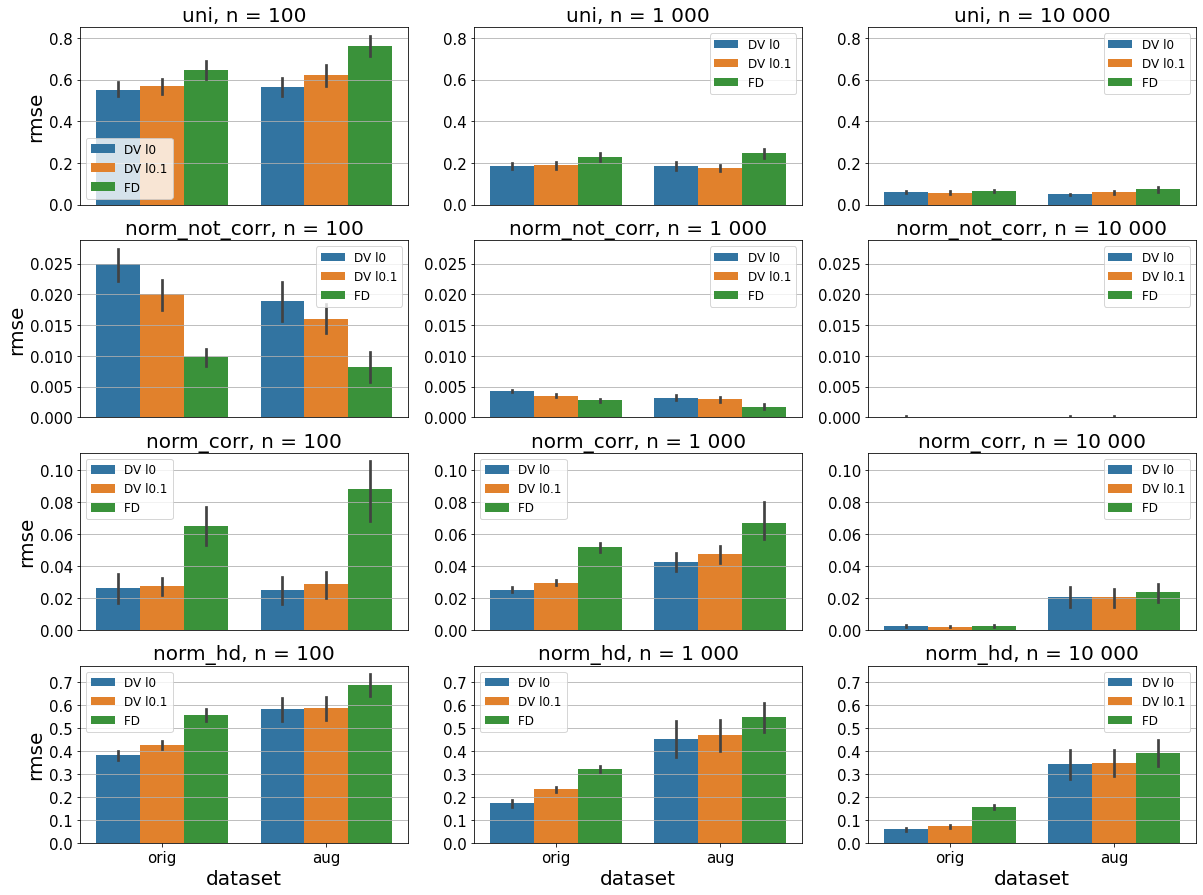

In [202]:
for i, dataset in enumerate(['uni', 'norm_not_corr', 'norm_corr', 'norm_hd']):
    ax = plt.subplot(4, 3, i*3+1)
    d = data_for_boxplot(100, dataset)
    d['rmse'] = d['mi_estimate'] - theoretical(dataset)
    sns.barplot(x='dataset', y='rmse', hue='model', data=d, estimator=lambda x: np.sqrt(np.mean(x[~np.isnan(x)]**2)))
    plt.grid(axis='y')
    plt.title(dataset + ", n = 100", size=20)
    if i != 3:
        plt.xlabel('')
        plt.xticks([])
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.legend(fontsize=12)

    plt.subplot(4, 3, i*3+2, sharey=ax)
    d = data_for_boxplot(1000, dataset)
    d['rmse'] = d['mi_estimate'] - theoretical(dataset)
    sns.barplot(x='dataset', y='rmse', hue='model', data=d, estimator=lambda x: np.sqrt(np.mean(x[~np.isnan(x)]**2)))
    plt.grid(axis='y')
    plt.title(dataset + ", n = 1 000", size=20)
    if i != 3:
        plt.xlabel('')
        plt.xticks([])
    plt.ylabel('')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.legend(fontsize=12)

    plt.subplot(4, 3, i*3+3, sharey=ax)
    d = data_for_boxplot(10000, dataset)
    d['rmse'] = d['mi_estimate'] - theoretical(dataset)
    sns.barplot(x='dataset', y='rmse', hue='model', data=d, estimator=lambda x: np.sqrt(np.mean(x[~np.isnan(x)]**2)))
    plt.grid(axis='y')
    plt.title(dataset + ", n = 10 000", size=20)
    if i != 3:
        plt.xlabel('')
        plt.xticks([])
    plt.ylabel('')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.legend(fontsize=12)
    
    plt.savefig("figs/mine_errors.png")

In [195]:
results['uni'][10000]['orig']['DV']['l0']

array([2.69059767, 2.71394454, 2.69452656, 2.71698034, 2.71938508,
       2.68647087, 2.7221348 , 2.70751324, 2.70882428, 2.70719457,
       2.70506987, 2.70884955, 2.73431461, 2.70069026, 2.74205454,
       2.71172716, 2.73413014, 2.72857283, 2.73782736, 2.71242035,
       2.69694451, 2.71321799, 2.71989036, 2.72453516, 2.69523421,
       2.71491738, 2.73338255, 2.7114964 , 2.73449657, 2.68571356])

In [19]:
agg_results['norm_corr'][10000]

{'orig': {'DV': {'l0': array([0.16714794, 0.0016338 ]),
   'l0.01': array([0.16676543, 0.00122058])},
  'FD': array([0.16346808, 0.00186082])},
 'aug': {1: {'DV': {'l0': array([0.15170411, 0.01604341]),
    'l0.01': array([0.15162001, 0.01557475])},
   'FD': array([0.1476193 , 0.01578093])}}}

(array([4., 1., 0., 1., 1., 2., 3., 5., 8., 5.]),
 array([0.11333429, 0.11862799, 0.12392169, 0.1292154 , 0.1345091 ,
        0.13980281, 0.14509651, 0.15039022, 0.15568392, 0.16097762,
        0.16627133]),
 <BarContainer object of 10 artists>)

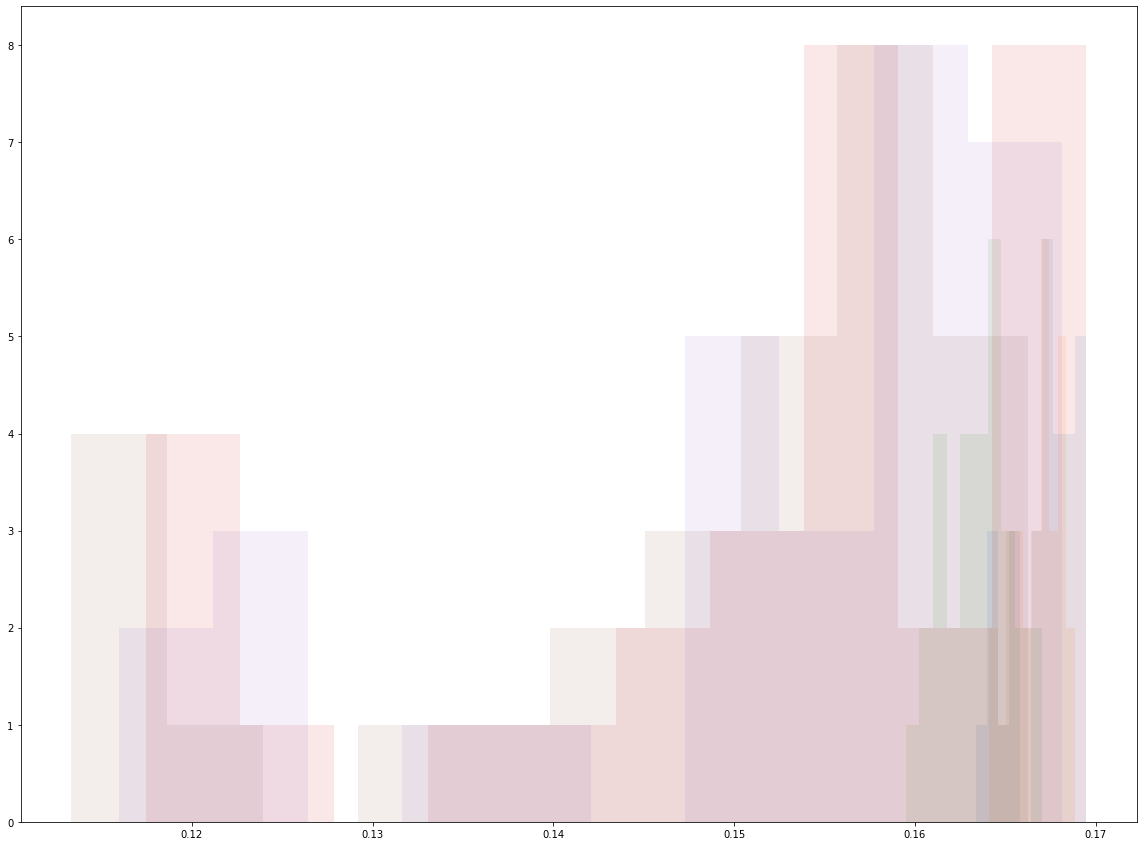

In [23]:
plt.hist(results['norm_corr'][10000]['orig']['DV']['l0'], alpha=0.1)
plt.hist(results['norm_corr'][10000]['orig']['DV']['l0.01'], alpha=0.1)
plt.hist(results['norm_corr'][10000]['orig']['FD'], alpha=0.1)
plt.hist(results['norm_corr'][10000]['aug'][1]['DV']['l0'], alpha=0.1)
plt.hist(results['norm_corr'][10000]['aug'][1]['DV']['l0.01'], alpha=0.1)
plt.hist(results['norm_corr'][10000]['aug'][1]['FD'], alpha=0.1)

In [20]:
agg_results['uni'][10_000]

{'orig': {'DV': {'l0': array([2.71376858, 0.01524346]),
   'l0.01': array([2.71767311, 0.01854644])},
  'FD': array([2.70913482, 0.0137489 ])},
 'aug': {1: {'DV': {'l0': array([2.72453281, 0.01099625]),
    'l0.01': array([2.7163495 , 0.01632797])},
   'FD': array([2.70309115, 0.02565717])}}}

In [62]:
np.log(16)

2.772588722239781

In [51]:
agg_results['uni'][10_000]

{'orig': {'DV': {'l0': array([2.71376858, 0.01524346]),
   'l0.01': array([2.71767311, 0.01854644])},
  'FD': array([2.70913482, 0.0137489 ])},
 'aug': {1: {'DV': {'l0': array([2.72453281, 0.01099625]),
    'l0.01': array([2.7163495 , 0.01632797])},
   'FD': array([2.70309115, 0.02565717])}}}

In [63]:
0

0

In [52]:
agg_results['norm_not_corr'][10_000]

{'orig': {'DV': {'l0': array([1.36284447e-04, 2.00800117e-05]),
   'l0.01': array([8.68142060e-05, 2.54043101e-05])},
  'FD': array([-2.05077065e-05,  3.61071415e-05])},
 'aug': {1: {'DV': {'l0': array([1.18395283e-04, 6.36643434e-05]),
    'l0.01': array([8.21072129e-05, 8.03573902e-05])},
   'FD': array([-3.57340442e-05,  8.57723808e-05])}}}

In [64]:
cov = np.array([[1, 0.75], [0.75, 2]])

In [71]:
corr = cov[0, 1] / np.diag(cov).prod()
-np.log(1-corr**2)

0.15154989812720093

In [53]:
agg_results['norm_corr'][10_000]

{'orig': {'DV': {'l0': array([0.16714794, 0.0016338 ]),
   'l0.01': array([0.16676543, 0.00122058])},
  'FD': array([0.16346808, 0.00186082])},
 'aug': {1: {'DV': {'l0': array([0.15170411, 0.01604341]),
    'l0.01': array([0.15162001, 0.01557475])},
   'FD': array([0.1476193 , 0.01578093])}}}

In [54]:
agg_results['norm_hd'][10_000]

{'orig': {'DV': {'l0': array([0.98236736, 0.01757195]),
   'l0.01': array([0.96831684, 0.02025248])},
  'FD': array([0.88407467, 0.02910383])},
 'aug': {1: {'DV': {'l0': array([0.73991332, 0.17052888]),
    'l0.01': array([0.72998941, 0.16373027])},
   'FD': array([0.67754018, 0.15434584])}}}

In [55]:
agg_results['uni'][1_000]

{'orig': {'DV': {'l0': array([2.59029922, 0.03846824]),
   'l0.01': array([2.58843283, 0.04849442])},
  'FD': array([2.54885998, 0.0543272 ])},
 'aug': {1: {'DV': {'l0': array([2.59602988, 0.05254346]),
    'l0.01': array([2.60241867, 0.03991218])},
   'FD': array([2.53392521, 0.06241149])}}}

In [56]:
agg_results['norm_not_corr'][1_000]

{'orig': {'DV': {'l0': array([0.00427846, 0.00065769]),
   'l0.01': array([0.00344664, 0.00072902])},
  'FD': array([0.00264695, 0.00074817])},
 'aug': {1: {'DV': {'l0': array([0.00296615, 0.00120738]),
    'l0.01': array([0.00248446, 0.00152663])},
   'FD': array([0.00136366, 0.00107539])}}}

In [61]:
agg_results['norm_corr'][1_000]

{'orig': {'DV': {'l0': array([0.14013552, 0.00419119]),
   'l0.01': array([0.13577635, 0.00436386])},
  'FD': array([0.11393547, 0.00762922])},
 'aug': {1: {'DV': {'l0': array([0.12515381, 0.01526401]),
    'l0.01': array([0.11973464, 0.01443856])},
   'FD': array([0.10253657, 0.02321204])}}}

In [59]:
agg_results['norm_hd'][1_000]

{'orig': {'DV': {'l0': array([0.87114977, 0.04009885]),
   'l0.01': array([0.80673225, 0.02648478])},
  'FD': array([0.71971281, 0.03797282])},
 'aug': {1: {'DV': {'l0': array([0.62729143, 0.1876523 ]),
    'l0.01': array([0.60498222, 0.17762977])},
   'FD': array([0.51764454, 0.16641396])}}}